# Predictiva posterior y comparacion de modelos

En este notebook se realizan las predicciones predictivas posteriores con los modelos ajustados con iniciales informativas. Ademas, se realiza comparacion de modelos con los criterios estudiados en clase.

In [1]:
# import all libraries used in this notebook
import os
import numpy as np
import pandas as pd
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.core.magic import register_cell_magic
import time
import arviz as az
import xarray as xr
from outils import load_config, log_run
from statistics import mean
from predictiva_posterior import ajuste_posterior_predictiva, grafica_hist_replicaciones_observados
from predictiva_posterior import grafica_media_std_replicaciones, grafica_scatter_estadisticas 
from predictiva_posterior import calcula_metricas, loglik_posterior_predictiva

In [2]:
# Load config file calling load_config function
config_f = load_config("config.yaml")
LOGFILE = config_f["log_file"]

### Datos

In [3]:
radon = pd.read_csv(os.path.join(config_f["data_directory"],"radon.csv"))
mn_radon = radon[radon['state']=='MN'].reset_index(drop=True)
mn_radon.drop(columns=['state'], inplace=True)
mn_radon['county_id'] = pd.factorize(mn_radon['county'])[0]+ 1
mn_radon['radon_natural'] = mn_radon['log_radon'].apply(np.exp)

### Diccionario de datos

In [4]:
radon_data = {"N": len(mn_radon), 
              "x": mn_radon.floor.astype(float), 
              "y": mn_radon.log_radon,
              "J":85, 
              "county" : mn_radon.county_id}

## Predictiva posterior

## Modelo 1: Regresion Lineal (no multinivel) coeficientes invariantes por condado

### Modelo agrupado

$ \large log\_radon_i = \alpha + \beta Piso_i + \epsilon_i$

$\large \alpha \sim N(1,1)$ <br>
$\large \beta \sim N(0,1)$ <br>
$\large \sigma \sim N(0,1)$

In [8]:
modelString="""
        data {
        int<lower=1> N;
        vector[N] x;
        vector[N] y;
    }
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    model {
        y ~ normal(alpha + beta * x, sigma);
        alpha ~ normal(1, 1);
        beta ~ normal(0, 1);
        sigma ~ normal(0, 1);
    }
    generated quantities {
        array[N] real y_rep = normal_rng(alpha + beta * x, sigma);
    }
"""

In [9]:
parametros_modelo1, predicciones_natural_modelo1, estadisticas_replicaciones_modelo1, muestras_aleatorias_modelo1, ajuste_modelo1 = \
ajuste_posterior_predictiva(
    "modelo_agrupado_posterior.stan",
    modelString, radon_data,
    mn_radon,
    ['alpha', 'beta', 'sigma'],
    10000, 3)

09:19:33 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_agrupado_posterior.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_agrupado_posterior
09:19:46 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_agrupado_posterior
09:19:46 - cmdstanpy - INFO - CmdStan start processing
09:19:46 - cmdstanpy - INFO - Chain [1] start processing
09:19:46 - cmdstanpy - INFO - Chain [2] start processing
09:19:46 - cmdstanpy - INFO - Chain [3] start processing
09:19:50 - cmdstanpy - INFO - Chain [3] done processing
09:19:50 - cmdstanpy - INFO - Chain [2] done processing
09:19:50 - cmdstanpy - INFO - Chain [1] done processing
09:19:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: 

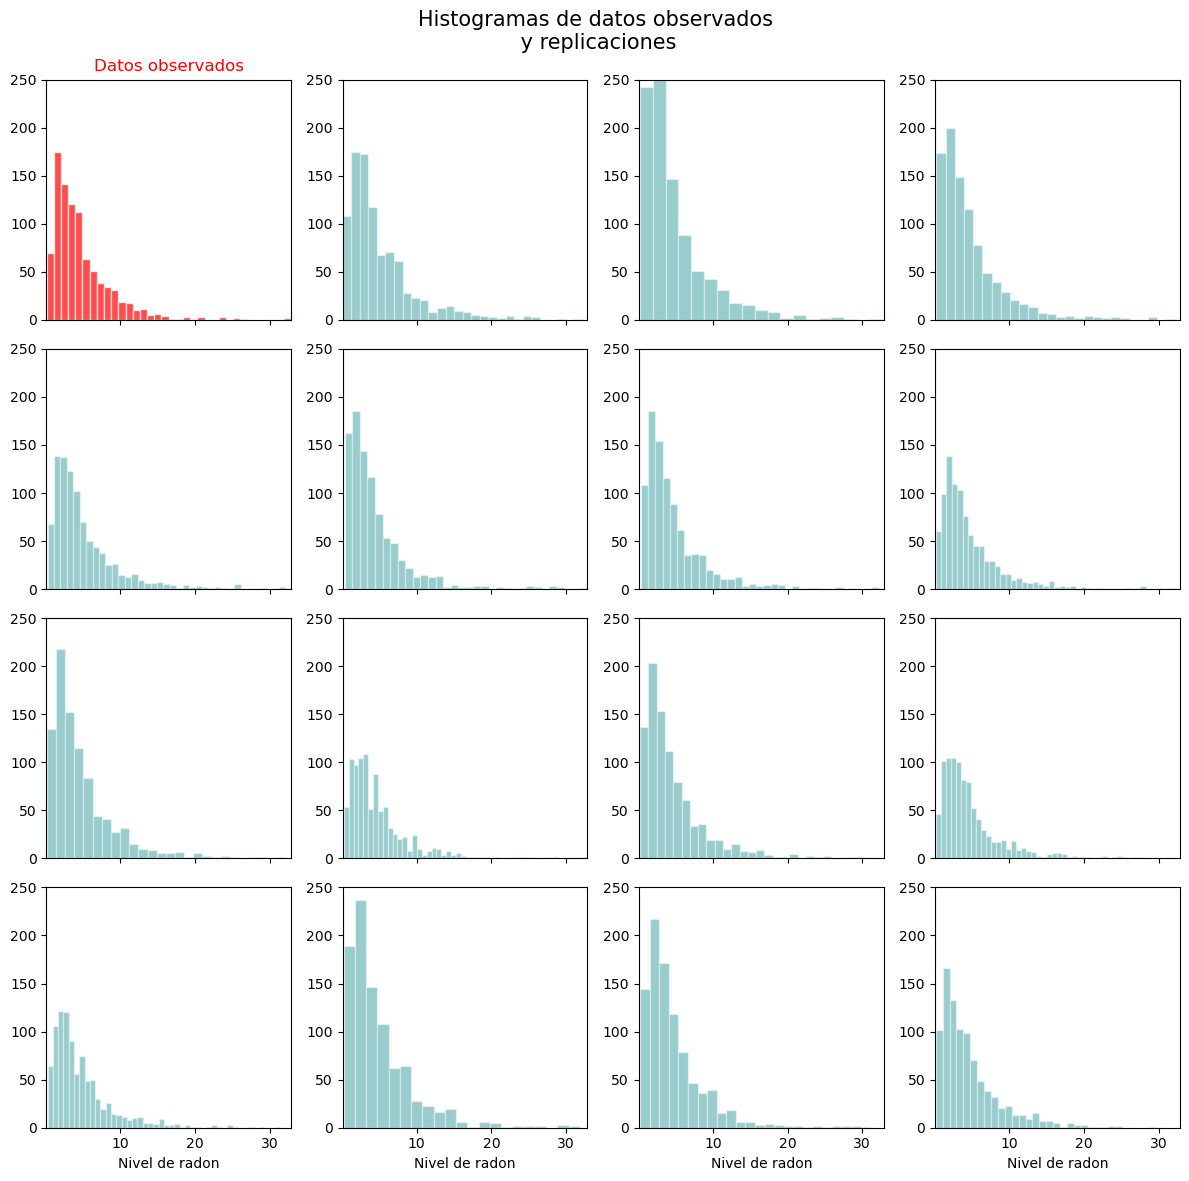

In [10]:
grafica_hist_replicaciones_observados(muestras_aleatorias_modelo1)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo1_histogramas"))

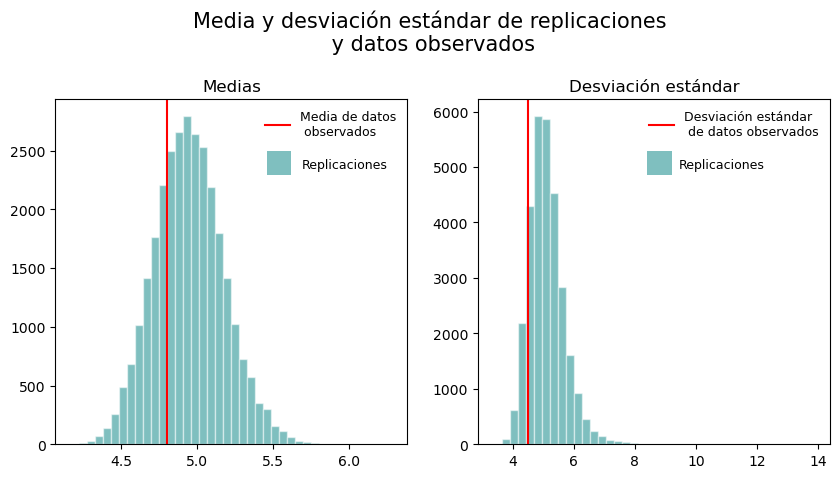

In [11]:
grafica_media_std_replicaciones(estadisticas_replicaciones_modelo1, mn_radon)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo1_media_std_hist"))

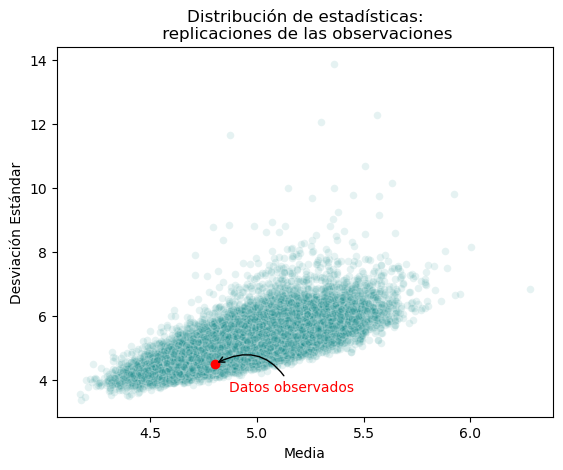

In [12]:
grafica_scatter_estadisticas(estadisticas_replicaciones_modelo1, mn_radon)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo1_estadisticas"))

### Criterios de ajuste

## CRITERIOS DE AJUSTE: modelo 1

In [13]:
modelString="""
        data {
        int<lower=1> N;
        vector[N] x;
        vector[N] y;
    }
    parameters {
        real alpha;
        real beta;
        real<lower=0> sigma;
    }
    model {
        y ~ normal(alpha + beta * x, sigma);
        alpha ~ normal(1, 1);
        beta ~ normal(0, 1);
        sigma ~ normal(0, 1);
    }
    generated quantities {
        array[N] real log_lik;
        for (n in 1:N)
            log_lik[n] = normal_lpdf(y[n] | alpha + beta * x[n], sigma);
    }
"""

In [14]:
parametros_modelo1, ajuste_modelo1 = \
loglik_posterior_predictiva(
    "modelo_agrupado_posterior.stan",
    modelString, radon_data,
    mn_radon,
    ['alpha', 'beta', 'sigma'],
    10000, 3)

09:22:17 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_agrupado_posterior.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_agrupado_posterior
09:22:31 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_agrupado_posterior
09:22:31 - cmdstanpy - INFO - CmdStan start processing
09:22:31 - cmdstanpy - INFO - Chain [1] start processing
09:22:31 - cmdstanpy - INFO - Chain [2] start processing
09:22:31 - cmdstanpy - INFO - Chain [3] start processing
09:22:36 - cmdstanpy - INFO - Chain [2] done processing
09:22:36 - cmdstanpy - INFO - Chain [1] done processing
09:22:37 - cmdstanpy - INFO - Chain [3] done processing
09:22:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: 

In [15]:
waic_modelo1, loo_modelo1 = calcula_metricas(ajuste_modelo1, ["alpha", "beta", "sigma"], n_chains=3, n_draws_per_chain=10000)

In [16]:
waic_modelo1

Computed from 30000 posterior samples and 927 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1148.68    25.84
p_waic        3.79        -

In [17]:
loo_modelo1

Computed from 30000 posterior samples and 927 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1148.68    25.84
p_loo        3.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      927  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Modelo 2: Regresion Lineal (no multinivel) intercepto variantes por condado

### Modelo no agrupado

$ \large log\_radon_i = \alpha_{j[i]} + \beta Piso_i + \epsilon_i$

$\large \alpha_j \sim N(1,1)$ <br>
$\large \beta \sim N(0,1)$ <br>
$\large \sigma \sim N(0,1)$

In [18]:
modelString="""
    data {
        int<lower=1> N;  // observations
        int<lower=1> J;  // counties
        array[N] int<lower=1, upper=J> county;
        vector[N] x;     // floor
        vector[N] y;     // radon
    }
    parameters {
        vector[J] alpha;
        real beta;
        real<lower=0> sigma;
    }
    model {
        y ~ normal(alpha[county] + beta * x, sigma);  
        alpha ~ normal(1, 1);
        beta ~ normal(0, 1);
        sigma ~ normal(0, 1);
    }
    generated quantities {
        array[N] real y_rep = normal_rng(alpha[county] + beta * x, sigma);
    }
"""

In [19]:
parametros_modelo2, predicciones_natural_modelo2, estadisticas_replicaciones_modelo2, muestras_aleatorias_modelo2, ajuste_modelo2 = \
ajuste_posterior_predictiva("modelo_no_agrupado_posterior.stan",modelString, radon_data, mn_radon, ["alpha","beta","sigma"], 10000, 3)

09:54:58 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_no_agrupado_posterior.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_no_agrupado_posterior
09:55:13 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_no_agrupado_posterior
09:55:13 - cmdstanpy - INFO - CmdStan start processing
09:55:13 - cmdstanpy - INFO - Chain [1] start processing
09:55:13 - cmdstanpy - INFO - Chain [2] start processing
09:55:13 - cmdstanpy - INFO - Chain [3] start processing
09:55:20 - cmdstanpy - INFO - Chain [3] done processing
09:55:21 - cmdstanpy - INFO - Chain [1] done processing
09:55:21 - cmdstanpy - INFO - Chain [2] done processing


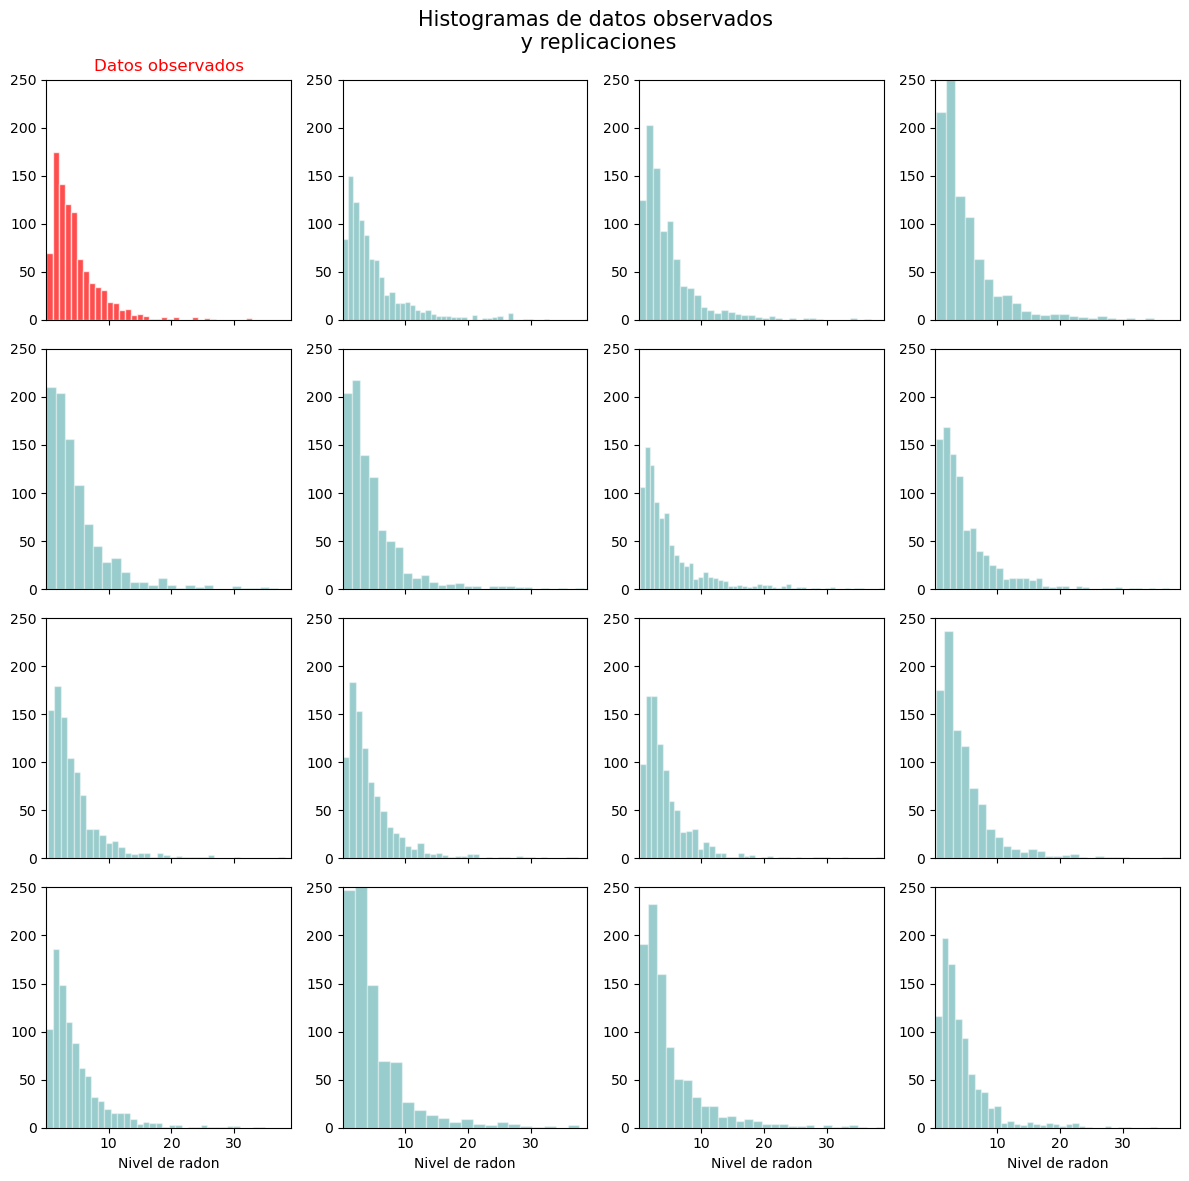

In [20]:
grafica_hist_replicaciones_observados(muestras_aleatorias_modelo2)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo2_histogramas"))

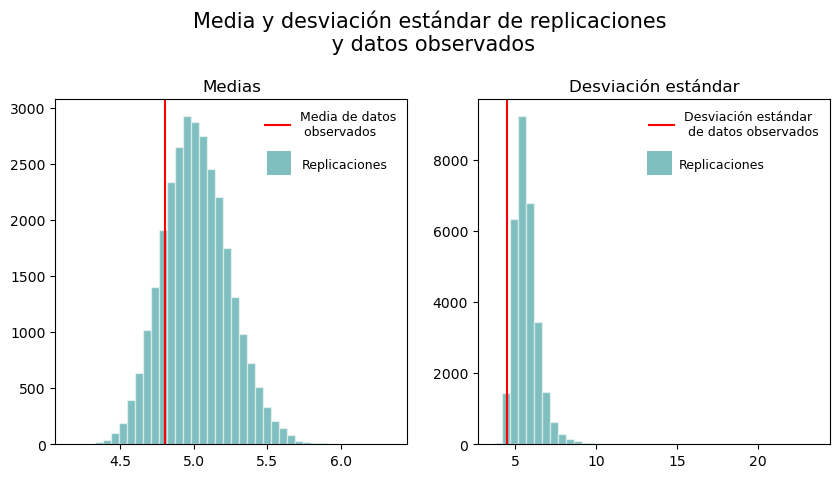

In [21]:
grafica_media_std_replicaciones(estadisticas_replicaciones_modelo2, mn_radon)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo2_media_std_hist"))

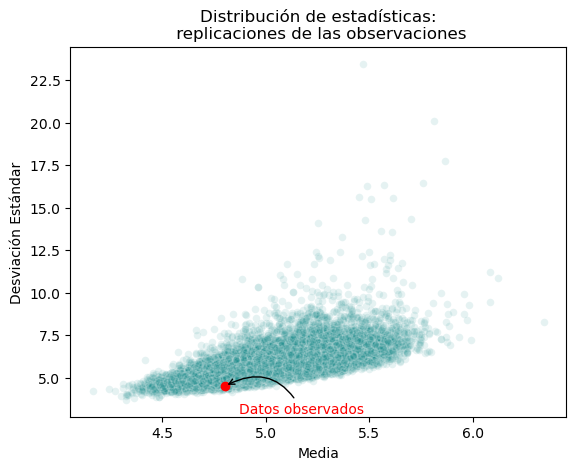

In [22]:
grafica_scatter_estadisticas(estadisticas_replicaciones_modelo2, mn_radon)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo2_estadisticas"))

#### Definicion de lista de parametros

In [23]:
lista_parametros_modelo2=parametros_modelo2.columns
params_modelo2=[]
for i in lista_parametros_modelo2:
    params_modelo2.append(i)

## CRITERIOS DE AJUSTE: modelo 2

In [24]:
modelString="""
    data {
        int<lower=1> N;  // observations
        int<lower=1> J;  // counties
        array[N] int<lower=1, upper=J> county;
        vector[N] x;     // floor
        vector[N] y;     // radon
    }
    parameters {
        vector[J] alpha;
        real beta;
        real<lower=0> sigma;
    }
    model {
        y ~ normal(alpha[county] + beta * x, sigma);  
        alpha ~ normal(1, 1);
        beta ~ normal(0, 1);
        sigma ~ normal(0, 1);
    }
    generated quantities {
        array[N] real log_lik;
        for (n in 1:N)
            log_lik[n] = normal_lpdf(y[n] | alpha[county[n]] + beta * x[n], sigma);
    }
"""

In [25]:
parametros_modelo2, ajuste_modelo2 = \
loglik_posterior_predictiva(
    "modelo_no_agrupado_posterior.stan",
    modelString, radon_data,
    mn_radon,
    ['alpha', 'beta', 'sigma'],
    10000, 3)

09:57:19 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_no_agrupado_posterior.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_no_agrupado_posterior
09:57:33 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_no_agrupado_posterior
09:57:33 - cmdstanpy - INFO - CmdStan start processing
09:57:33 - cmdstanpy - INFO - Chain [1] start processing
09:57:33 - cmdstanpy - INFO - Chain [2] start processing
09:57:33 - cmdstanpy - INFO - Chain [3] start processing
09:57:38 - cmdstanpy - INFO - Chain [3] done processing
09:57:38 - cmdstanpy - INFO - Chain [2] done processing
09:57:39 - cmdstanpy - INFO - Chain [1] done processing


In [26]:
waic_modelo2, loo_modelo2 = calcula_metricas(ajuste_modelo2, ['alpha', 'beta', 'sigma'], n_chains=3, n_draws_per_chain=10000)

In [27]:
waic_modelo2

Computed from 30000 posterior samples and 927 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1107.25    28.54
p_waic       73.36        -

There has been a warning during the calculation. Please check the results.

In [28]:
loo_modelo2

Computed from 30000 posterior samples and 927 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1110.04    28.68
p_loo       76.14        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      913   98.5%
 (0.5, 0.7]   (ok)         11    1.2%
   (0.7, 1]   (bad)         3    0.3%
   (1, Inf)   (very bad)    0    0.0%

## Modelo 3: modelo jerarquico intercepto variantes por condado (partial pooling)

### Modelo parcialmente agrupado

$\large yi = \alpha_{j[i]}+\beta  X_i + \epsilon_i$

$\large \alpha_j \sim N(\mu_\alpha,\sigma_\alpha)$ <br>
$\large \mu_\alpha \sim N(0,1)$ <br>
$\large \sigma_\alpha \sim N(0,1)$ <br>
$\large \beta \sim N(0,1)$ <br>
$\large \sigma \sim N(0,1)$

In [31]:
modelString="""
    data {
        int<lower=1> N;  // observations
        int<lower=1> J;  // counties
        array[N] int<lower=1, upper=J> county;
        vector[N] x;
        vector[N] y;
    }
    parameters {
        real mu_alpha;
        real<lower=0> sigma_alpha;
        vector<offset=mu_alpha, multiplier=sigma_alpha>[J] alpha;  // non-centered parameterization
        real beta;
        real<lower=0> sigma;
    }
    model {
        y ~ normal(alpha[county] + beta * x, sigma);  
        alpha ~ normal(mu_alpha, sigma_alpha); // partial-pooling
        beta ~ normal(0, 1);
        sigma ~ normal(0, 1);
        mu_alpha ~ normal(1, 1);
        sigma_alpha ~ normal(0, 1);
    }
    generated quantities {
        array[N] real y_rep = normal_rng(alpha[county] + beta * x, sigma);
    }
"""


In [32]:
parametros_modelo3, predicciones_natural_modelo3, estadisticas_replicaciones_modelo3, muestras_aleatorias_modelo3, ajuste_modelo3= \
ajuste_posterior_predictiva("modelo_parcialmente_agrupado_posteriorA.stan",
                            modelString,
                            radon_data,
                            mn_radon,
                            ['alpha', 'beta', 'sigma','mu_alpha','sigma_alpha'],
                            20000,
                            3)

10:10:34 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorA.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorA
10:10:49 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorA
10:10:49 - cmdstanpy - INFO - CmdStan start processing
10:10:49 - cmdstanpy - INFO - Chain [1] start processing
10:10:49 - cmdstanpy - INFO - Chain [2] start processing
10:10:49 - cmdstanpy - INFO - Chain [3] start processing
10:11:08 - cmdstanpy - INFO - Chain [3] done processing
10:11:08 - cmdstanpy - INFO - Chain [1] done processing
10:11:09 - cmdstanpy - INFO - Chain [2] done processing
10:11:09 - cmdstanpy - WARNING - No

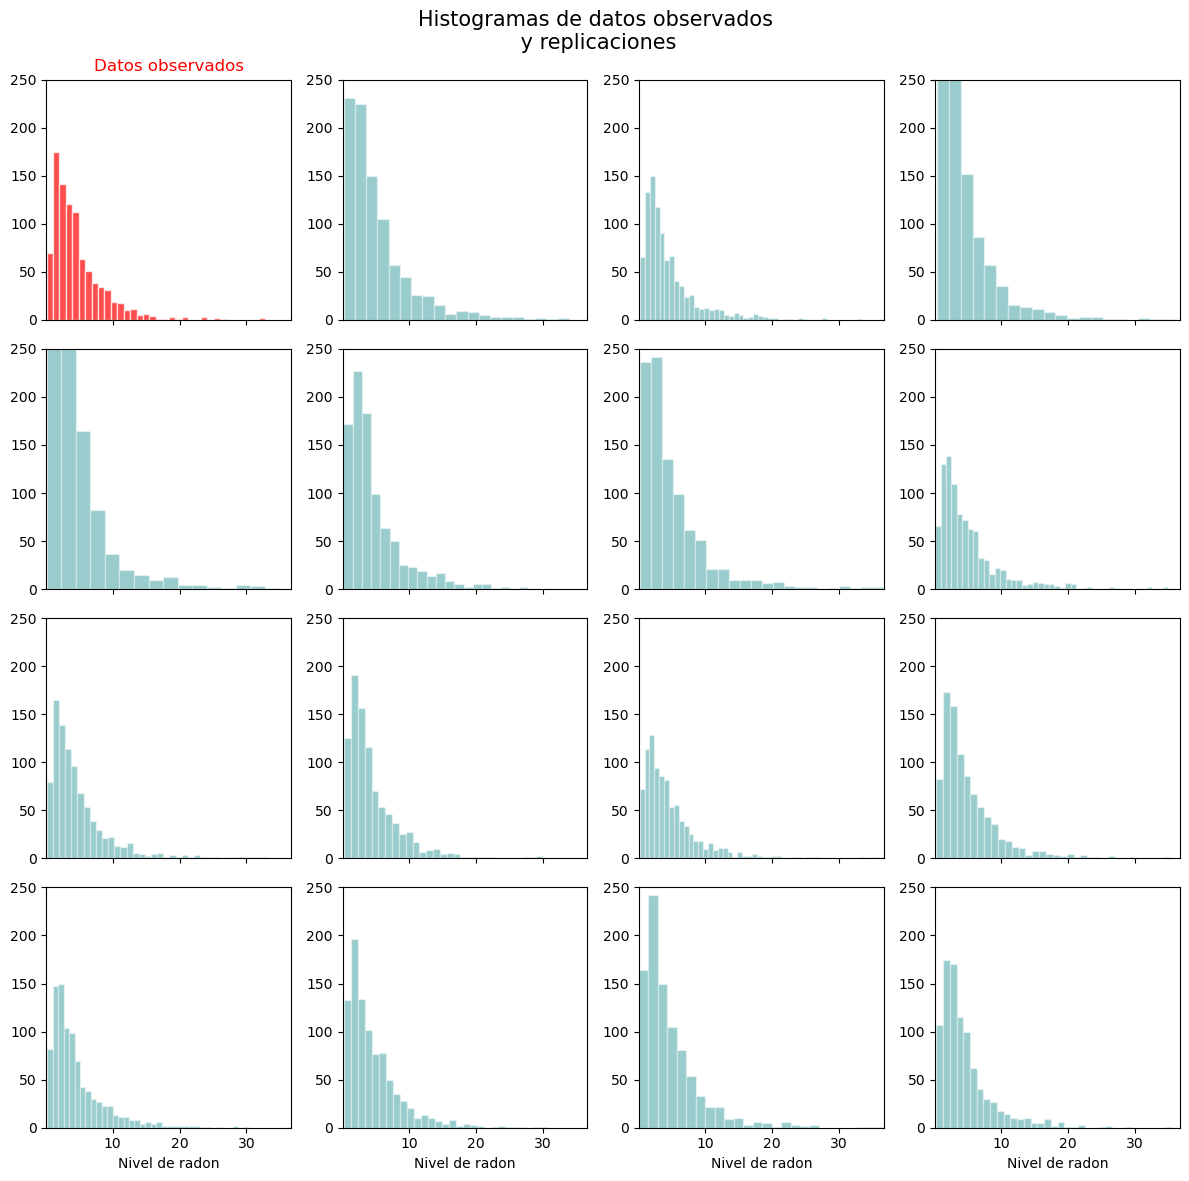

In [33]:
grafica_hist_replicaciones_observados(muestras_aleatorias_modelo3)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo3_histogramas"))

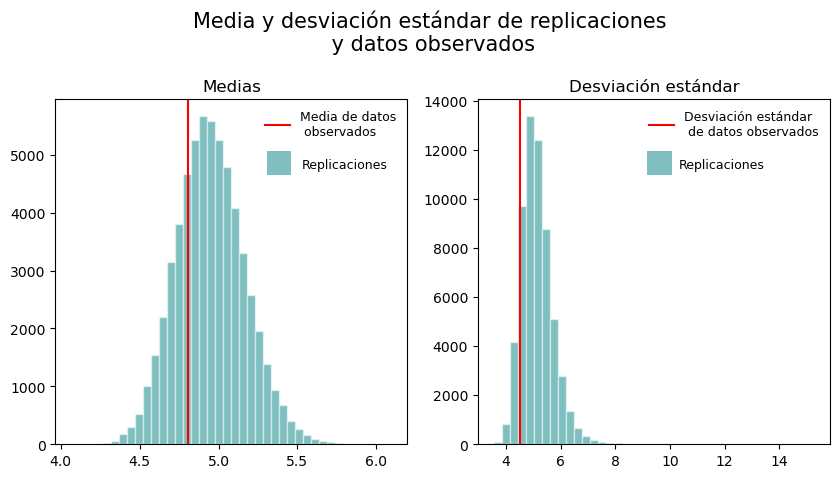

In [34]:
grafica_media_std_replicaciones(estadisticas_replicaciones_modelo3, mn_radon)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo3_media_std_hist"))

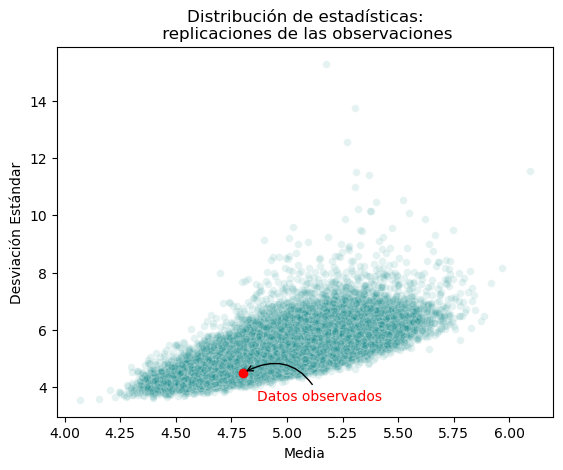

In [35]:
grafica_scatter_estadisticas(estadisticas_replicaciones_modelo3, mn_radon)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo3_estadisticas"))

## CRITERIOS DE AJUSTE: modelo 3

In [36]:
modelString="""
    data {
        int<lower=1> N;  // observations
        int<lower=1> J;  // counties
        array[N] int<lower=1, upper=J> county;
        vector[N] x;
        vector[N] y;
    }
    parameters {
        real mu_alpha;
        real<lower=0> sigma_alpha;
        vector<offset=mu_alpha, multiplier=sigma_alpha>[J] alpha;  // non-centered parameterization
        real beta;
        real<lower=0> sigma;
    }
    model {
        y ~ normal(alpha[county] + beta * x, sigma);  
        alpha ~ normal(mu_alpha, sigma_alpha); // partial-pooling
        beta ~ normal(0, 1);
        sigma ~ normal(0, 1);
        mu_alpha ~ normal(1, 1);
        sigma_alpha ~ normal(0, 1);
    }
    generated quantities {
        array[N] real log_lik;
        for (n in 1:N)
            log_lik[n] = normal_lpdf(y[n] | alpha[county[n]] + beta * x[n], sigma);
    }
"""


In [37]:
parametros_modelo3, ajuste_modelo3 = \
loglik_posterior_predictiva("modelo_parcialmente_agrupado_posteriorA.stan",
                            modelString,
                            radon_data,
                            mn_radon,
                            ['alpha', 'beta', 'sigma','mu_alpha','sigma_alpha'],
                            20000,
                            3)

10:13:27 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorA.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorA
10:13:41 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorA
10:13:41 - cmdstanpy - INFO - CmdStan start processing
10:13:41 - cmdstanpy - INFO - Chain [1] start processing
10:13:41 - cmdstanpy - INFO - Chain [2] start processing
10:13:41 - cmdstanpy - INFO - Chain [3] start processing
10:13:58 - cmdstanpy - INFO - Chain [1] done processing
10:13:58 - cmdstanpy - INFO - Chain [2] done processing
10:13:59 - cmdstanpy - INFO - Chain [3] done processing
10:13:59 - cmdstanpy - WARNING - No

In [38]:
waic_modelo3, loo_modelo3 = calcula_metricas(ajuste_modelo3, ['alpha', 'beta', 'sigma','mu_alpha','sigma_alpha'], n_chains=3, n_draws_per_chain=20000)

In [39]:
waic_modelo3

Computed from 60000 posterior samples and 927 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1093.99    28.76
p_waic       49.19        -

There has been a warning during the calculation. Please check the results.

In [40]:
loo_modelo3

Computed from 60000 posterior samples and 927 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1094.44    28.79
p_loo       49.63        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      927  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## 4 Modelo parcialmente agrupado: distintos interceptos y coeficientes por condado

Modelo parcialmente agrupado B

$ \large log\_radon_i  \sim N( \alpha_{j[i]} + \beta_j Piso_i  , \sigma)$ <br>

$\large \alpha_j \sim N(\mu_\alpha,\sigma_\alpha)$ <br>
$\large \mu_\alpha \sim N(1,1)$ <br>
$\large \sigma_\alpha \sim N(0,1)$ <br>
$\large \beta_j \sim N(\mu_\beta,\sigma_\beta)$ <br>
$\large \mu_\beta \sim N(0,1)$ <br>
$\large \sigma_\beta \sim N(0,1)$ <br>
$\large \sigma \sim N(0,1)$

In [5]:
modelString="""
    data {
        int<lower=1> N;  // observations
        int<lower=1> J;  // counties
        array[N] int<lower=1, upper=J> county;
        vector[N] x;
        vector[N] y;
    }
    parameters {
        real mu_alpha;
        real<lower=0> sigma_alpha;
        vector<offset=mu_alpha, multiplier=sigma_alpha>[J] alpha;  // non-centered parameterization
        real mu_beta;
        real<lower=0> sigma_beta;
        vector<offset=mu_beta, multiplier=sigma_beta>[J] beta; // non-centered parameterization
        real<lower=0> sigma;
    }
    model {
        y ~ normal(alpha[county] + beta[county] .* x, sigma);
        alpha ~ normal(mu_alpha, sigma_alpha); // partial-pooling
        beta ~ normal(mu_beta, sigma_beta); // partial-pooling
        mu_alpha ~ normal(1, 1);
        sigma_alpha ~ normal(0, 1);
        mu_beta ~ normal(0, 1);
        sigma_beta ~ normal(0, 1);
        sigma ~ normal(0, 1);
    }
    generated quantities {
        array[N] real y_rep;      
        for (i in 1:N) {
            y_rep[i] = normal_rng(alpha[county[i]] + beta[county[i]] * x[i], sigma);
        }
    }
"""


In [6]:
%%log_run Mejor modelo
parametros_modelo4, predicciones_natural_modelo4, estadisticas_replicaciones_modelo4, muestras_aleatorias_modelo4, ajuste_modelo4 = \
ajuste_posterior_predictiva("modelo_parcialmente_agrupado_posteriorB.stan",
                            modelString, radon_data,
                            mn_radon,
                            ['alpha', 'beta', 'sigma','mu_alpha','sigma_alpha','mu_beta','sigma_beta'],
                            20000,
                            3)

13:05:49 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorB.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorB
13:06:04 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorB
13:06:04 - cmdstanpy - INFO - CmdStan start processing
13:06:04 - cmdstanpy - INFO - Chain [1] start processing
13:06:04 - cmdstanpy - INFO - Chain [2] start processing
13:06:04 - cmdstanpy - INFO - Chain [3] start processing
13:06:36 - cmdstanpy - INFO - Chain [3] done processing
13:06:42 - cmdstanpy - INFO - Chain [2] done processing
13:06:42 - cmdstanpy - INFO - Chain [1] done processing
13:06:42 - cmdstanpy - WARNING - No

<ExecutionResult object at 7f891b363950, execution_count=None error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 7f891b363510, raw_cell="parametros_modelo4, predicciones_natural_modelo4, .." store_history=False silent=False shell_futures=True cell_id=None> result=None>

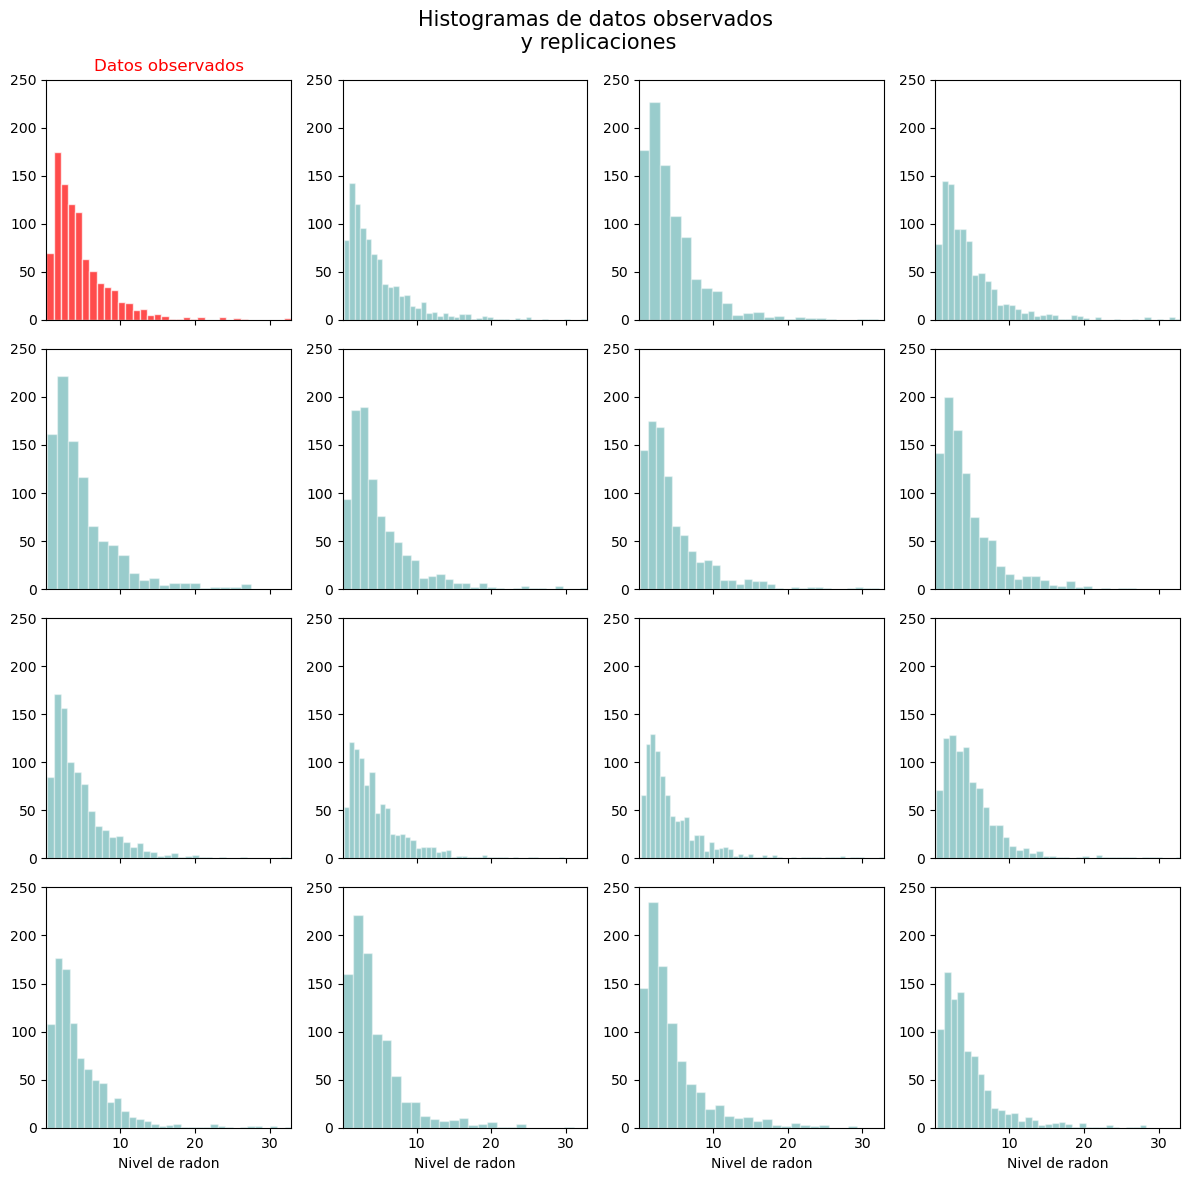

In [47]:
grafica_hist_replicaciones_observados(muestras_aleatorias_modelo4)
plt.savefig(os.path.join(config_f["results_directory"], 
                         "PPost_modelo4_histogramas"))

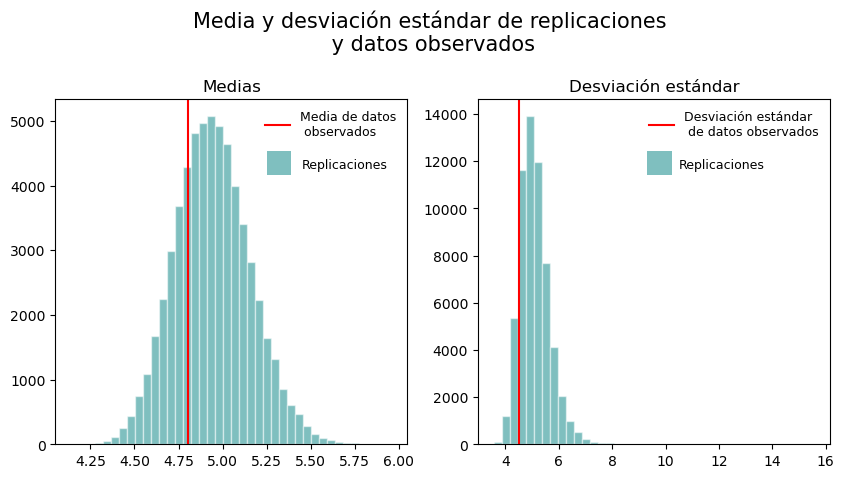

In [48]:
grafica_media_std_replicaciones(estadisticas_replicaciones_modelo4, mn_radon)
plt.savefig(os.path.join(config_f["results_directory"], 
                         "PPost_modelo4_media_std_hist"))

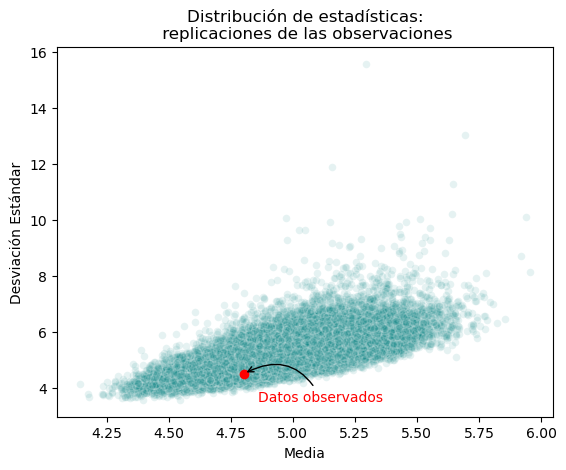

In [49]:
grafica_scatter_estadisticas(estadisticas_replicaciones_modelo4, mn_radon)
plt.savefig(os.path.join(config_f["results_directory"], "PPost_modelo4_estadisticas"))

### Comparacion de modelos

## CRITERIOS DE AJUSTE: modelo 4

In [50]:
modelString="""
    data {
        int<lower=1> N;  // observations
        int<lower=1> J;  // counties
        array[N] int<lower=1, upper=J> county;
        vector[N] x;
        vector[N] y;
    }
    parameters {
        real mu_alpha;
        real<lower=0> sigma_alpha;
        vector<offset=mu_alpha, multiplier=sigma_alpha>[J] alpha;  // non-centered parameterization
        real mu_beta;
        real<lower=0> sigma_beta;
        vector<offset=mu_beta, multiplier=sigma_beta>[J] beta; // non-centered parameterization
        real<lower=0> sigma;
    }
    model {
        y ~ normal(alpha[county] + beta[county] .* x, sigma);
        alpha ~ normal(mu_alpha, sigma_alpha); // partial-pooling
        beta ~ normal(mu_beta, sigma_beta); // partial-pooling
        mu_alpha ~ normal(1, 1);
        sigma_alpha ~ normal(0, 1);
        mu_beta ~ normal(0, 1);
        sigma_beta ~ normal(0, 1);
        sigma ~ normal(0, 1);
    }
    generated quantities {
        array[N] real log_lik;
        
        for (i in 1:N) {
            log_lik[i] = normal_lpdf(y[i] | alpha[county[i]] + beta[county[i]] * x[i], sigma);
        }
    }
"""


In [51]:
parametros_modelo4, ajuste_modelo4 = \
loglik_posterior_predictiva("modelo_parcialmente_agrupado_posteriorB.stan",
                            modelString, radon_data,
                            mn_radon,
                            ['alpha', 'beta', 'sigma','mu_alpha','sigma_alpha','mu_beta','sigma_beta'],
                            20000,
                            3)

10:54:04 - cmdstanpy - INFO - compiling stan file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorB.stan to exe file /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorB
10:54:19 - cmdstanpy - INFO - compiled model executable: /home/juanpalms/Desktop/MCD/Bayesiana/PROYECTO/modelacion-bayesiana-proyecto-final-bayes-radioactivo/modelos/modelo_parcialmente_agrupado_posteriorB
10:54:19 - cmdstanpy - INFO - CmdStan start processing
10:54:19 - cmdstanpy - INFO - Chain [1] start processing
10:54:19 - cmdstanpy - INFO - Chain [2] start processing
10:54:19 - cmdstanpy - INFO - Chain [3] start processing
10:54:42 - cmdstanpy - INFO - Chain [3] done processing
10:54:43 - cmdstanpy - INFO - Chain [1] done processing
10:54:51 - cmdstanpy - INFO - Chain [2] done processing
10:54:51 - cmdstanpy - WARNING - No

In [52]:
waic_modelo4, loo_modelo4 = calcula_metricas(ajuste_modelo4, ['alpha', 'beta', 'sigma','mu_alpha','sigma_alpha','mu_beta','sigma_beta']
                                             , n_chains=3, n_draws_per_chain=20000)

In [53]:
waic_modelo4

Computed from 60000 posterior samples and 927 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -1094.82    29.29
p_waic       64.44        -

There has been a warning during the calculation. Please check the results.

In [54]:
loo_modelo4

Computed from 60000 posterior samples and 927 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1096.28    29.46
p_loo       65.90        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      919   99.1%
 (0.5, 0.7]   (ok)          8    0.9%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [64]:

modelos_dict = {"Modelo completamente agrupado": waic_modelo1, 
                "Modelo no agrupado": waic_modelo2,
                "Modelo parcialmente agrupado (intercepto)": waic_modelo3,
                "Modelo parcialmente agrupado (intercepto y coeficiente)": waic_modelo4}  
comparacion = az.compare(modelos_dict)
print(comparacion)

                                                    rank    elpd_waic   
Modelo parcialmente agrupado (intercepto)              0 -1093.994482  \
Modelo parcialmente agrupado (intercepto y coef...     1 -1094.819935   
Modelo no agrupado                                     2 -1107.250041   
Modelo completamente agrupado                          3 -1148.681637   

                                                       p_waic  elpd_diff   
Modelo parcialmente agrupado (intercepto)           49.189673   0.000000  \
Modelo parcialmente agrupado (intercepto y coef...  64.435118   0.825453   
Modelo no agrupado                                  73.356855  13.255559   
Modelo completamente agrupado                        3.794491  54.687155   

                                                      weight         se   
Modelo parcialmente agrupado (intercepto)           0.408391  28.757563  \
Modelo parcialmente agrupado (intercepto y coef...  0.475840  29.292040   
Modelo no agrupado          

Text(0, 0.5, 'Ranking de modelos')

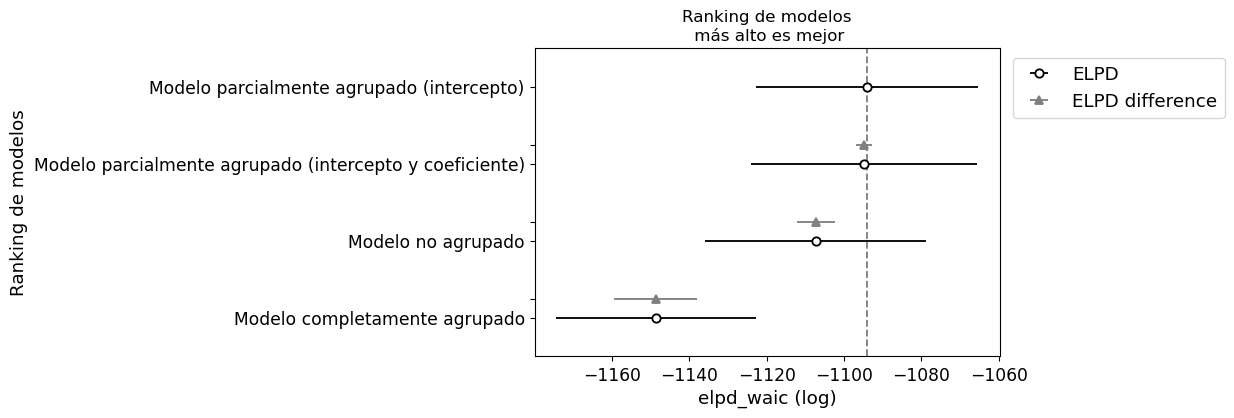

In [72]:
axes = az.plot_compare(comparacion)
axes.set_title('Ranking de modelos\n más alto es mejor')
axes.set_ylabel("Ranking de modelos")

## Referencias

Comparacion de modelos:<br>
https://mc-stan.org/loo/reference/compare.html <br>
Calculo de metricas de comparacion: <br>
https://python.arviz.org/en/stable/api/generated/arviz.compare.html <br>
Graficas de diagnosticos predictivos posteriores: <br>
Adapatadas a python del codigo del profesor Alfredo Garbuno